# Advanced Data Analysis using Python

In this seminar we demonstrate a few of the ``Python`` ecosystem tools that enable **research** in areas that can be very difficult to do in traditional tools such as ``Stata`` that are typically fit-for-purpose tools. 

The agility of a full programming language environment allows for a high degree of flexibility and Python provides a vast toolkit to remain productive. 


## Network Analysis

Interest in studying networks is increasing within **Economics** with recent publications building network type features into their models, or using network analysis to uncover structural features of data that may otherwise go unexplored. 


## What is a Network (Graph)?

Many people who have interacted with tools from network analysis have done so via the idea of Social Network Analysis (SNA). 

    A Graph is a way of specifying relationships among a collection of items

They consist of a collection of **nodes** (or vertices) that are joined together by **edges**. 

An **undirected graph** is an ordered pair G = (V, E) comprising a set V of vertices or nodes or points together with a set E of edges or arcs or lines, which are 2-element subsets of V.

$$
G = (V,E)
$$

The structure of these relationships can be exploited to understand new insights into the data such as finding:

1. Communities (through Clustering)
1. Main Actors in Social Networks (Centrality)
1. Identifying indirect relationships through shortest / longest paths
1. Diffusion characteristics (such as disease transmission modeling)
1. Strong and Weak ties using Edge characteristics

In [1]:
%matplotlib inline
import networkx as nx

In [2]:
g = nx.Graph()
g.add_edge("A","B")   #Add Edge between Nodes A and B
g.add_edge("A","C")   #Add Edge between Nodes A and C
g.add_edge("A","D")   #Add Edge between Nodes A and D

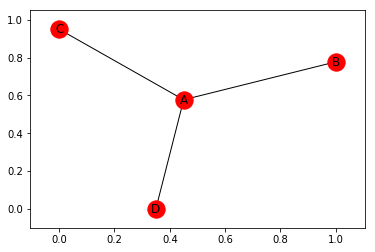

In [3]:
nx.draw_networkx(g)

#### You can use network metrics to learn more about the structure. What is the most central node?

In [4]:
nx.degree_centrality(g)

{'A': 1.0,
 'B': 0.3333333333333333,
 'C': 0.3333333333333333,
 'D': 0.3333333333333333}

In [5]:
g.add_edge("C","D")

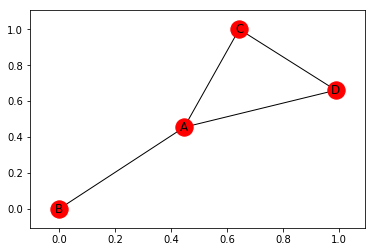

In [6]:
nx.draw_networkx(g)

In [7]:
nx.degree_centrality(g)

{'A': 1.0,
 'B': 0.3333333333333333,
 'C': 0.6666666666666666,
 'D': 0.6666666666666666}

### Social Network Example: Karate Club (Zachary, 1977)

One early example of Social Network Analysis was conducted by Zachary (1977) who set out to use network analysis to explain factional dynamics and to understand **fission in small groups.** A network of **friendship** was used to understand and identify how this Karate group eventually split due to an initial conflict between two members.

- **Nodes:** Individuals
- **Edges:** Connections were added between two individuals if they were consistently observed to interact outside the normal activities of the club. 

![Karate 1](./img/karate-club-1-combined.png) 

#### We can learn things by considering the structure of these networks

This dataset is frequently used in the development of clustering algorithms that aim to reveal information about the system that would have been previously unknown. One such visualization (Cao, 2013) demonstrates how algorithmic analysis can reveal meaningful structure that clearly identifies roles played by certain individuals, that is based on observing simple pairs of friends. 

![Karate 2](./img/karate-club-2.png)


------------------

## Replicating the Product Space Network using International Trade Data (Hidalgo, 2007)

Let's focus on an application of network analysis that is applied to a dataset, that is relatively large, to replicate some of the results contained in the Hidalgo (2007) paper and later in the [The Atlas of Complexity](http://atlas.cid.harvard.edu/) and [The Observatory of Economic Complexity](http://atlas.media.mit.edu/en/).

The Hidalgo (2007) paper is used as a **motivating example** to demonstrate various tools that are available in the ``Python`` ecosystem.

Let's look at one characterisation of International Trade data by considering:
- **Nodes:** Products
- **Edges:** the likelihood of being co-exported

**Assumption:** If products are often co-exported across countries, then the products are more likely to share similar factors of production (or capabilities) that are required to produce them. For example, Shirts and Pants require a set of similar skills to produce and are likely to be co-exported. 

This relational information between products can be represented by a high valued edge weight.

Let's work with a Toy Example with 8 products

In [8]:
g = nx.Graph()
g.add_nodes_from(["Shirts", "Pants", "Oil", "Cars", "Aircraft", "Wheat", "Sugar", "Cows"])
g.add_edge("Shirts", "Pants", attr_dict={'weight' : 0.9})
g.add_edge("Shirts", "Cars", attr_dict={'weight' : 0.2})
g.add_edge("Shirts", "Cows", attr_dict={'weight' : 0.01})
g.add_edge("Shirts", "Sugar", attr_dict={'weight' : 0.01})
g.add_edge("Pants", "Cars", attr_dict={'weight' : 0.2})
g.add_edge("Oil", "Sugar", attr_dict={'weight' : 0.01})
g.add_edge("Oil", "Cars", attr_dict={'weight' : 0.005})
g.add_edge("Oil", "Aircraft", attr_dict={'weight' : 0.005})
g.add_edge("Cars", "Aircraft", attr_dict={'weight' : 0.5})
g.add_edge("Cars", "Aircraft", attr_dict={'weight' : 0.5})
g.add_edge("Wheat", "Sugar", attr_dict={'weight' : 0.4})
g.add_edge("Cows", "Sugar", attr_dict={'weight' : 0.1})
g.add_edge("Cows", "Cars", attr_dict={'weight' : 0.001})
g.add_edge("Cows", "Pants", attr_dict={'weight' : 0.06})

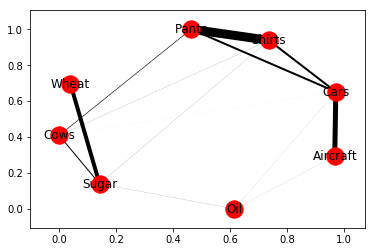

In [9]:
pos = nx.spring_layout(g)
weights = [g[u][v]['weight']*10 for u,v in g.edges()]
nx.draw_networkx(g, pos=pos, width=weights)

We can investigate this network using yearly cross-sectional information from international trade data.

The **tasks** involve using product level international export data to:

1. Compute Revealed Comparative Advantage and $M_{cp}$ matrices [**Tools: Pandas**]
1. Compute Proximity Matrices ($\phi_{pp'}$) and make this code run fast [**Tools: Pandas, Numpy, Numba, Dask**]
1. Building Networks and Plotting Product Space Network Diagrams - albiet not as fancy [**Tools: NetworkX**]

![Product Space](./img/atlas_productspace.png)



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import networkx as nx
from bokeh.io import output_notebook

In [11]:
#-Load Jupyter Extensions-#
%matplotlib inline
output_notebook()

Loading BokehJS ...

## Data

International Trade Data is largely available in SITC and HS product classification systems. 

In this notebook we will focus on SITC revision 2 Level 4 data with ``786`` defined products. 

|Classification | Level | Products |
|---------------|-------|----------|
|SITC           | 4     | 786      |
|HS             | 6     | 5016     |

**Note:** 

We use ``SITC`` data in this seminar, but as you can see performance of code becomes even more important when working with fully disaggregated ``HS`` international trade data

In [12]:
fl = "./data/year_origin_sitc_rev2.csv"
data = pd.read_csv(fl, converters={'sitc':str})   #Import SITC codes as strings to preserve formatting

In [13]:
data.head()

,year,origin,sitc,export
0,1962,AFG,0230,4000.0
1,1962,AFG,0250,66000.0
2,1962,AFG,0540,74000.0
3,1962,AFG,0545,17000.0
4,1962,AFG,0548,33000.0


### Question 1: What years are available in this dataset?

**Hint:** There is a method named ``unique()``, so you should get the array of years and then call ``.unique()``

<button data-toggle="collapse" data-target="#sol1" class='btn btn-primary'>Solution</button>
<div id="sol1" class="collapse">
```python
data['year'].unique()
```

### Question 2: How many non-zero trade flow values are in this dataset?

<button data-toggle="collapse" data-target="#sol2" class='btn btn-primary'>Solution</button>
<div id="sol2" class="collapse">
```python
data.shape[0]
```

### Question 3: What countries are available in this dataset?

<button data-toggle="collapse" data-target="#sol3" class='btn btn-primary'>Solution</button>
<div id="sol3" class="collapse">
```python
data['origin'].unique()
```

In [14]:
data[(data['year'] == 2000)&(data['origin']=="AUS")].head()

,year,origin,sitc,export
2213361,2000,AUS,0011,260132101.0
2213362,2000,AUS,0012,167611315.0
2213363,2000,AUS,0013,280098.0
2213364,2000,AUS,0014,548603.0
2213365,2000,AUS,0015,134571371.0


In [15]:
data[data['origin'] == 'AUS'].set_index(["year","sitc"])["export"].unstack(level="year").head()

year,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
sitc,,,,,,,,,,,,,,,,,,,,,
0010,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,1000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011,1286000.0,675000.0,1177000.0,1700000.0,748000.0,548000.0,586000.0,747000.0,331000.0,443000.0,...,283381176.0,284544151.0,365401097.0,571444736.0,586230117.0,793934945.0,650001457.0,627274883.0,728998394.0,1.114734e+09
0012,2600000.0,3619000.0,5593000.0,3560000.0,4725000.0,5078000.0,5578000.0,6828000.0,11517000.0,13321000.0,...,211748259.0,215548475.0,216467212.0,307677017.0,296862273.0,319842757.0,347639153.0,296233596.0,174194459.0,2.209887e+08
0013,26000.0,52000.0,81000.0,69000.0,60000.0,32000.0,99000.0,108000.0,108000.0,189000.0,...,260620.0,309274.0,549802.0,153458.0,37764.0,224888.0,NaN,NaN,345256.0,2.302240e+05
0014,375000.0,398000.0,445000.0,187000.0,83000.0,73000.0,30000.0,83000.0,263000.0,258000.0,...,592790.0,2842029.0,3599939.0,4708910.0,6542608.0,5466152.0,5372783.0,4237839.0,1165708.0,3.056300e+05


---------------

## Computing Revealed Comparative Advantage

The literature uses the standard Balassa definition for Revealed Comparative Advantage

$$
\large
RCA_{cpt} = \frac{\frac{E_{cpt}}{E_{ct}}}{\frac{E_{pt}}{E_t}}
$$

where,

1. $E_{cpt}$ are exports from country $c$ in product $p$ at time $t$
1. $E_{ct}$ are total country $c$ exports at time $t$
1. $E_{pt}$ are total product $p$ exports at time $t$
1. $E_{t}$ are total world exports at time $t$

**Reference:** Balassa, B. (1965), Trade Liberalisation and Revealed Comparative Advantage, The Manchester School, 33, 99-123.

To compute **RCA** we need to aggregate data at difference levels to obtain each component of the fraction defined above. 

Let's break the equation down to figure out what needs to be computed:

$$
\large
E_{ct} = \sum_{ct}{E_{cpt}}
$$

In [16]:
cntry_export = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).sum()
cntry_export.head(n=2)

export
year origin             
1962 AFG      86135000.0
     AGO     119458000.0

This gives us a ``pandas.DataFrame`` that is indexed by a multi-index object. This can be very useful but we would like to use this data in the original data table for each product exported at time t by each country. We could use this new object and:

1. ``merge`` the data back into the original data DataFrame
2. use ``transform`` to request an object that is of the same shape as the original data DataFrame. 

In [17]:
data[["year", "origin", "export"]].groupby(by=["year", "origin"]).transform(np.sum).head(n=2)

,export
0,86135000.0
1,86135000.0


In [18]:
#-This can be added to the initial data table as a column-#
data["cntry_export"] = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).transform(np.sum)

In [19]:
#-We have now added the same value for each product exported by AFG in 1962
data.head(n=2)

,year,origin,sitc,export,cntry_export
0,1962,AFG,0230,4000.0,86135000.0
1,1962,AFG,0250,66000.0,86135000.0


#### Compute Total Product Export, and Total World Export

In [20]:
data["prod_export"] = data[["year", "sitc", "export"]].groupby(by=["year", "sitc"]).transform(np.sum)
data["world_export"] = data[["year", "export"]].groupby(by=["year"]).transform(np.sum)

Now that the components of the equation have been computed we can now simply calculate $RCA$ as expressed by the original fraction

In [21]:
data["rca"] = (data["export"] / data["cntry_export"]) / (data["prod_export"] / data["world_export"])

In [22]:
data.head()

,year,origin,sitc,export,cntry_export,prod_export,world_export,rca
0,1962,AFG,0230,4000.0,86135000.0,438581000.0,1.428420e+11,0.015125
1,1962,AFG,0250,66000.0,86135000.0,261448000.0,1.428420e+11,0.418634
2,1962,AFG,0540,74000.0,86135000.0,48924000.0,1.428420e+11,2.508338
3,1962,AFG,0545,17000.0,86135000.0,349188000.0,1.428420e+11,0.080736
4,1962,AFG,0548,33000.0,86135000.0,85126000.0,1.428420e+11,0.642877


---------------__
## Computing $M_{cp}$ Matrix: Who Exports What Products and When?

$RCA >= 1$ is where country $c$ has a revealed comparative advantage in product $p$ at time $t$

Therefore we can define the matrix $M_{cp}$:

$$
M_{cp} = 
\begin{cases}
  1 \text{ if  }RCA \ge 1\\    
  0 \text{ if  }RCA \lt 1   
\end{cases}
$$

We can first construct $RCA$ matrices and then compute $M_{cp}$ using a conditional map


In [23]:
#-Generate Yearly RCA Mcp Matrices and store them in a Dictionary-#
rca = {}
for year in data.year.unique():
    yr = data[data.year == year].set_index(['origin', 'sitc']).unstack('sitc')['rca']
    rca[year] = yr

In [24]:
rca[2000].head()

sitc,0011,0012,0013,0014,0015,0111,0112,0113,0114,0115,...,8994,8996,8997,8998,8999,9310,9410,9510,9610,9710
origin,,,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,0.000189,NaN,0.008223,NaN,NaN,...,NaN,0.009006,0.000910,0.006053,0.001468,1.264113,0.104766,NaN,NaN,0.76756
AFG,NaN,NaN,NaN,NaN,NaN,0.176481,0.066896,NaN,NaN,NaN,...,NaN,0.067773,0.782384,NaN,NaN,0.066374,NaN,NaN,NaN,NaN
AGO,NaN,NaN,0.000012,NaN,NaN,0.001756,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000137,NaN,0.026715,NaN,NaN,0.005944,NaN
AIA,NaN,NaN,NaN,NaN,NaN,15.716737,6.270237,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.649915,6.906314,NaN,NaN,NaN,NaN
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006836,NaN,...,0.304894,0.014938,0.146457,0.093441,NaN,0.357895,25.006762,NaN,3.426721,NaN


### Exercise 6: How can we use ``rca`` to compute the ``mcp`` matrix?

In [25]:
#-Generate Yearly Binary Mcp Matrices-#
mcp = {}
for year in rca.keys():
    mcp[year] = rca[year].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)

<button data-toggle="collapse" data-target="#sol7" class='btn btn-primary'>Solution</button>
<div id="sol7" class="collapse">
```python
#-Generate Yearly Binary Mcp Matrices-#
mcp = {}
for year in rca.keys():
    mcp[year] = rca[year].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)
```

### Question: What is the key assumption implied by the above code?

In [26]:
mcp[2000].head()

sitc,0011,0012,0013,0014,0015,0111,0112,0113,0114,0115,...,8994,8996,8997,8998,8999,9310,9410,9510,9610,9710
origin,,,,,,,,,,,,,,,,,,,,,
ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AIA,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Question 6: What products did Australia ("AUS") export with RCA in 1998?

<button data-toggle="collapse" data-target="#sol8" class='btn btn-primary'>Solution</button>
<div id="sol8" class="collapse">
```python
products = mcp[1998].loc['AUS']
products[products == 1.0]
```

--------------

## Computing Proximity Matrix $\phi_{ij}$

$$
\phi_{ij} = \min \{ P(RCA_i | RCA_j), P(RCA_j | RCA_i) \}
$$

The minimum **conditional probability of coexport** can be computed:

$$
\phi_{ij} = \frac{\sum_c \{ M_{cp_i} * M_{cp_j} \}}{max \{k_{p_i}, k_{p_j}\}}
$$

where,

1. $k_{p_i}$ is the ubiquity of product $i$ (i.e. the number of countries that export product $i$)
2. $k_{p_j}$ is the ubiquity of product $j$ (i.e. the number of countries that export product $j$)
2. $M_{cp_i}$ is the column vector in $M_{cp}$ matrix for product $i$
3. $M_{cp_j}$ is the column vector in $M_{cp}$ matrix for product $j$
4. $\sum_c \{ M_{cp_i} * M_{cp_j} \}$ is the number of countries that export both product $i$ and product $j$

The $\phi_{ij}$ matrix is therefore computed through all pairwise combinations of column vectors which is computationally intensive.

#### Compute Proximity Matrix using Pandas

In [27]:
def proximity_matrix_pandas(mcp, fillna=True):
    products = sorted(list(mcp.columns))
    sum_products = mcp.sum(axis=0)
    proximity = pd.DataFrame(index=products, columns=products)
    for product1 in products:
        for product2 in products:
            numerator = (mcp[product1] * mcp[product2]).sum()
            denominator = max(sum_products[product1], sum_products[product2])
            if denominator == 0:
                cond_prob =  np.nan
            else:
                cond_prob = numerator / denominator
            proximity.set_value(index=product1, col=product2, value=cond_prob)
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [28]:
%%time
prox_2000 = proximity_matrix_pandas(mcp[2000])

CPU times: user 2min 4s, sys: 1.17 s, total: 2min 5s
Wall time: 2min 4s


#### Check the Data (simple stats and visualizations)

Hidalgo (2007) suggests that 32% of values are < 0.1 and 65% of values are < 0.2

In [29]:
prox_2000.unstack().describe()

count    600625.000000
mean          0.159894
std           0.106652
min           0.000000
25%           0.081081
50%           0.142857
75%           0.222222
max           1.000000
dtype: float64

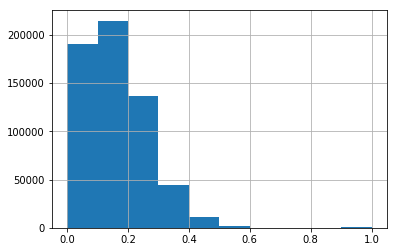

In [30]:
prox_2000.unstack().hist()

## But Wait - Problem!

at **~2 minutes** this is taking a long time to compute for one year.  This makes working with this data in an agile way problematic and computing for 50 years would take ~2 hours to compute. While this was easy to implement, it isn't very fast!

Let's **profile** this code to get an understanding where we spend most of our time

For this line to run you will need to install ``line_profiler`` by running:

```bash
conda install line_profiler
```

In [31]:
import line_profiler
%load_ext line_profiler

In [32]:
%lprun -f proximity_matrix_pandas proximity_matrix_pandas(mcp[2000])

*** KeyboardInterrupt exception caught in code being profiled.

## Step 1: Consider the Computation

Thinking about the details of the computation, the proximity matrix is symmetric because of the ``max`` condition in the denominator. Therefore we can reduce the redundant computation by computing only half of the matrix and using those values for both $i, j$ pairs.

Because product1 and product2 are string objects we will need some way of keeping track of our position when filling in the matrix values. 

This can be done using ``enumerate``

This will **half** the computation time.

In [33]:
def proximity_matrix_pandas_symmetry(mcp, fillna=True):
    products = sorted(list(mcp.columns))
    sum_products = mcp.sum(axis=0)
    proximity = pd.DataFrame(index=products, columns=products)
    for idx1, product1 in enumerate(products):
        for idx2, product2 in enumerate(products):
            if idx2 > idx1:  #Symmetric Matrix Condition
                continue
            numerator = (mcp[product1] * mcp[product2]).sum()
            denominator = max(sum_products[product1], sum_products[product2])
            if denominator == 0:
                cond_prob =  np.nan
            else:
                cond_prob = numerator / denominator
            proximity.set_value(index=product1, col=product2, value=cond_prob)
            proximity.set_value(index=product2, col=product1, value=cond_prob)
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [34]:
%%time
prox_2000_symmetry = proximity_matrix_pandas_symmetry(mcp[2000])

KeyboardInterrupt: 

In [ ]:
#-Check if the same results as brute force method-#
prox_2000.equals(prox_2000_symmetry)

## Step 2: Consider other Python Tools (NumPy)

Most of the time you will want to conduct **numerical** type computing in NumPy.

The code actually looks pretty similar - the main difference is conducting operations on pure numpy arrays

In [ ]:
def proximity_matrix_numpy(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    proximity = np.empty((num_products, num_products))
    col_sums = mcp.sum().values  
    data = mcp.T.as_matrix()                  #This generates a c x p numpy array
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [ ]:
%%time
prox_2000_numpy = proximity_matrix_numpy(mcp[2000])

In [ ]:
prox_2000.equals(prox_2000_numpy)

------------------------

## Step 3: Just in Time Compilation (Numba)

**Numba** is a package you can use to accelerate your code by using a technique called **just in time (or JIT)** compilation. It converts your high-level python code to low level llvm code to run it closer to the raw machine level. 

``nopython=True`` ensures the ``jit`` compiles without any ``python`` objects. If it cannot achieve this it will throw an error.

**Numba** now supports a lot of the ``NumPy`` api and can be checked [here](http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)

In [ ]:
@jit(nopython=True)
def coexport_probability(data, num_products, col_sums):
    proximity = np.empty((num_products, num_products))
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    return proximity

def proximity_matrix_numba(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    col_sums = mcp.sum().values  
    data = mcp.T.as_matrix()                  
    proximity = coexport_probability(data, num_products, col_sums)   #Call Jit Function
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [ ]:
prox_2000_numba = proximity_matrix_numba(mcp[2000])

In [ ]:
%%timeit
prox_2000_numba = proximity_matrix_numba(mcp[2000])

In [ ]:
prox_2000_numba.equals(prox_2000)

### Computing All Years

In [ ]:
%%time
proximity = {}
for year in mcp.keys():
    proximity[year] = proximity_matrix_numba(mcp[year])

In [ ]:
proximity[2000].head()

--------------------

## Using Dask to Compute all Years in Parallel

Now that we have a fast single year computation, we can compute all cross-sections serially using a loop.

Alternatively, we can parallelize these operations using ``Dask`` to delay computation and then ask the ``Dask`` scheduler to coordinate the computation over the number of **cores** available to you. This is particularly useful when using ``HS`` data. 

**Note:** This simple approach to parallelization does have some overhead to coordinate the computations so you won't get a full 4 x speed up when using a 4-core machine. 

In [ ]:
import dask
from distributed import Client
Client()

In [ ]:
#-Setup the Computations as a Collection of Tasks-#
collection = []
for year in sorted(mcp.keys()):
    collection.append((year, dask.delayed(proximity_matrix_numba)(mcp[year])))

In [ ]:
%%time
#-Compute the Results-#
result = dask.compute(*collection)

In [ ]:
#-Organise the list of returned tuples into a convenient dictionary-#
results = {}
for year, df in result:
    results[year] = df

In [ ]:
results[2000].equals(prox_2000)

In [ ]:
results[2000].head()

**Note:** [Dask](https://github.com/dask/dask) does a lot more than this and is worth looking into for medium to large scale computations

In [ ]:
#-Save Results into a HDF5 File-#
fl = "data/sitcr2l4_proximity.h5"
store = pd.HDFStore(fl, mode='w')
for year in results.keys():
    store["Y{}".format(year)] = results[year]

In [ ]:
store.close()

In [ ]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

--------------------------

## Performance Comparison (SITC and HS Data)

For **SITC** Data: (786 Products, 229 Countries, 52 Years)


| Function         | Time/Year        | Total Time  | Speedup |
|------------------|------------------|-------------|---------|
| pandas           | 220 seconds      | ~177 minutes| -       |
| pandas_symmetric | 104 seconds      | ~84 minutes | BASE       |
| numpy            | 2.5 seconds      | 120 seconds | ~41x    |
| numba            | 124 milliseconds | 6 seconds   | ~800x   |
| numba + dask     | N/A              | 5 seconds   | -       |



For **HS** Data: (5016 Products, 222 Countries, 20 Years)

| Function         | Time/Year                    | Total Time | Speedup |
|------------------|------------------------------|------------|---------|
| pandas           | 1 Hour 25 minutes |      -     | -       |
| pandas_symmetric | 43 minutes                   |      -     | BASE       |
| numpy            | 1 min 37 seconds             |      -     | ~28x    |
| numba            | 5 seconds                    | 1min 45 seconds   | ~516x   |
| numba + dask     | N/A                          | 45 seconds      |    -     |

These were run on the following **machine:**

| Item      | Details          |
|-----------|------------------|
| Processor | Xeon E5 @ 3.6Ghz |
| Cores     | 8                |
| RAM       | 32Gb RAM         |
| Python    | Python 3.6       |

------------------_

## (Extension) Preparing Graph Data: Product Space Network

Here we will use ``NetworkX`` to construct our version of the Product Space using Python

In [ ]:
prox = pd.read_hdf("data/sitcr2l4_proximity.h5", key="Y2000")

In [ ]:
prox.head()

#### use pandas to construct and edge list

In [ ]:
edge_list = prox.unstack()

In [ ]:
#-Construct Sequence of node pairs as a pd.Series
edge_list.head()

In [ ]:
#-Remove Self Loops-#
edge_list = edge_list[edge_list != 1.0]     #TODO: do this operation properly to compare node1 == node2

In [ ]:
edge_list.head()

#### We would like to construct the maximum_spanning_tree, but the current version of networkx supports minimum_spanning_tree so we need to add inv_weight for this computation. 

In [ ]:
#-Construct DataFrame-#
edge_list = edge_list.reset_index()
edge_list.columns = ["P1","P2","weight"]

In [ ]:
edge_list["inv_weight"] = 1 - edge_list['weight']    #Useful when working with minimum spanning tree in networkx

In [ ]:
edge_list.head()

In [ ]:
edge_list[["weight","inv_weight"]].hist();

# Network Tools

We want to now construct a maximum_spanning_tree and then add in all nodes that are highly connected above a threshold value of ``0.5``

In [ ]:
import networkx as nx

In [ ]:
#-Construct the complete network-#
g = nx.from_pandas_dataframe(edge_list, source="P1", target="P2", edge_attr=["weight", "inv_weight"])
print("# of Nodes: {}".format(g.number_of_nodes()))
print("# of Edges: {}".format(g.number_of_edges()))

In [ ]:
mst = nx.minimum_spanning_tree(g, weight='inv_weight') #Maximum Spanning Tree
print("# of Nodes: {}".format(mst.number_of_nodes()))
print("# of Edges: {}".format(mst.number_of_edges()))

In [ ]:
mst["0011"]

In [ ]:
#-Build Maximum Spanning Tree + Keep Edges > 0.50-#
ps = nx.Graph()
#Add MST ('weight' attribute only)
for u,v,w in mst.edges_iter(data=True):
    ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})
#Add Edges > 0.50
for u,v,w in g.edges_iter(data=True):
    if w['weight'] >= 0.50:
        ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})

In [ ]:
print("# of Nodes: {}".format(ps.number_of_nodes()))
print("# of Edges: {}".format(ps.number_of_edges()))

## Visualizations

In [ ]:
ps_nodes = pd.read_csv("data/PS_SITC_nodes", sep="\t", converters={'sitc' : str},
                       names=["sitc", "community", "x", "y", "nodesize","leamer","pname","ncolor"])
ps_edges = pd.read_csv("data/PS_SITC_edges", sep="\t", converters={'sourceid' : str, 'targetid' : str},
                       names=["sourceid", "sourcex", "sourcey","targetid","targetx","targety", "width","color"])

In [ ]:
ps_nodes.head()

In [ ]:
ps_nodes.shape

In [ ]:
def normalize(df, column):
    max_value = df[column].max()
    min_value = df[column].min()
    df[column+"_scaled"] = (df[column] - min_value) / (max_value - min_value)
    return df

In [ ]:
#Preprocess Coordinates to be Normalized between 0,1
ps_nodes = normalize(ps_nodes, 'x')
ps_nodes = normalize(ps_nodes, 'y')

In [ ]:
ps_nodes.head()

In [ ]:
import numpy as np
#-Obtain Dictionary of Coordinates-#
coord = {}
xy = ps_nodes[["x_scaled","y_scaled"]].values
for idx, productcode in enumerate(ps_nodes["sitc"]):
   coord[productcode] = xy[idx]
#-Add Missing Nodes-#
coord['6784'] = np.array([0,0])

In [ ]:
coord

In [ ]:
#-Check Entry-#
ps_nodes[ps_nodes.sitc == "0011"]

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(ps, ax=ax, pos=coord, node_size=750, width=1)
plt.savefig("productspace1.png")

**Note:** File is saved Locally to view the network in greater detail

In [ ]:
#-Let's See where Apparel Chapter 84 Nodes are Located-#
def choose_color(x):
    if x[:2] == "84":
        return "b"
    else:
        return "r"
    
nodes = pd.DataFrame(sorted(list(coord.keys())), columns=["nodeid"])
nodes["color"] = nodes["nodeid"].apply(lambda x: choose_color(x))

In [ ]:
nodes[nodes.color == 'b'].head()

In [ ]:
#-Get the Order of Nodes the Same as Network Node List
order = pd.DataFrame(ps.nodes()).reset_index()
order.columns = ["order", "nodeid"]
nodes = nodes.merge(order, how="inner", on="nodeid")
nodes = nodes.sort_values(by="order")

In [ ]:
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(ps, ax=ax, pos=coord, node_size=750, width=1, node_color = nodes.color.values, )
plt.savefig("productspace2.png")

In [ ]:
#Can Output to use with Gephi / Cytoscape (Exploratory Network Tools)
nx.write_gml(ps, "prouduct_space.gml")   

# References

[1] Zachary, W. (1977), "An Information Flow Model for Conflict and Fission in Small Groups", Journal of Anthropological Research, Vol. 33, No. 4 (Winter, 1977), pp. 452-473

[2] Cao, X., Wang X., Jin D., Cao Y. & He, D. (2013), "Identifying overlapping communities as well as hubs and outliers via nonnegative matrix factorization", Scientific Reports, Vol 3, Issue 2993

[3] Hidalgo, C.A., Klinger, B., Barabasi, A.-L., Hausmann, R. (2007), "The Product Space Conditions the Development of Nations", Science, Vol 317, pp 482-487

[4] Atlas of Complexity (http://atlas.cid.harvard.edu/)

[5] The Observatory of Economic Complexity (http://atlas.media.mit.edu/en/)

[6] Atlas of Complexity Gride Points for Nodes sourced from http://www.michelecoscia.com/?page_id=223

[7] Balassa, B. (1965), "Trade Liberalisation and Revealed Comparative Advantage", The Manchester School, 33, 99-123.